In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from filterpy.kalman import KalmanFilter
from filterpy.common import kinematic_kf
from tracking import ConstantUpdatePolicy, ResidualUpdatePolicy, RandomUpdatePolicy
from radar import Radar2D
from target import SingerModelMD, TargetOnTrajectory
from simulation import simulation_loop
from plotting import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


plt.style.use('ggplot')

# Simulate two dimensional Singer model

In [3]:
# Common parameters
dt = 0.01
horizon = 10000
t = dt*np.arange(horizon)

In [4]:
# Create simulation objects

target = SingerModelMD(
    stdAcc=0.4, 
    corrAcc=0.5, 
    x0=np.array([[5e3, -1e2, 0, 5e3, 1e2, 0]]), 
    dim=2, 
    dt=dt,
)

tracker = kinematic_kf(
    dim=2, 
    order=2,
    dt=0.1
)

radar = Radar2D(
    sn0=50,
    beamwidth=np.pi/64,
    prob_f=1e-8,
    order=2,
)

update_policy = ConstantUpdatePolicy(20)

In [5]:
# Initialize parameters
def initialize():
    target.reset()
    tracker.x = target.x
    tracker.P = 100*np.eye(6)
    tracker.Q = np.diag(np.linalg.eig(target.Q)[0])
    update_policy.reset()

In [6]:
initialize()
data = simulation_loop(target, radar, tracker, update_policy, horizon)

<IPython.core.display.Javascript object>


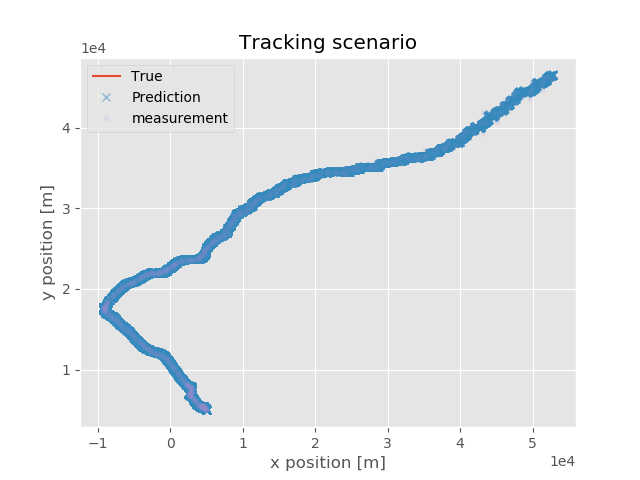

In [7]:
plot_scenario(data, 2)
plt.savefig('figs/scenario.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


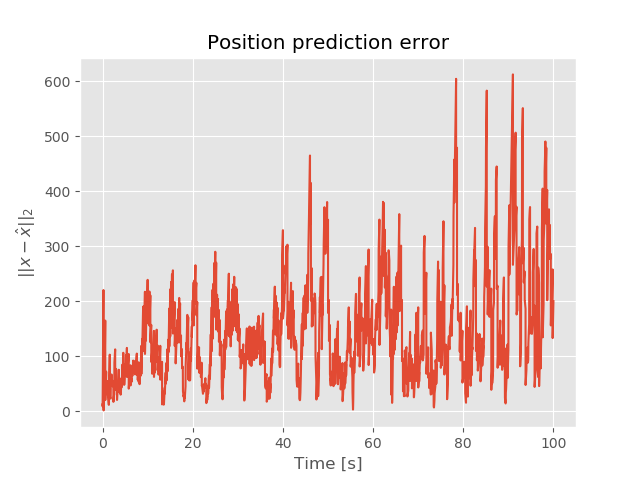

In [8]:
plot_prediction_error(data, t, 2)
plt.savefig('figs/position_error.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


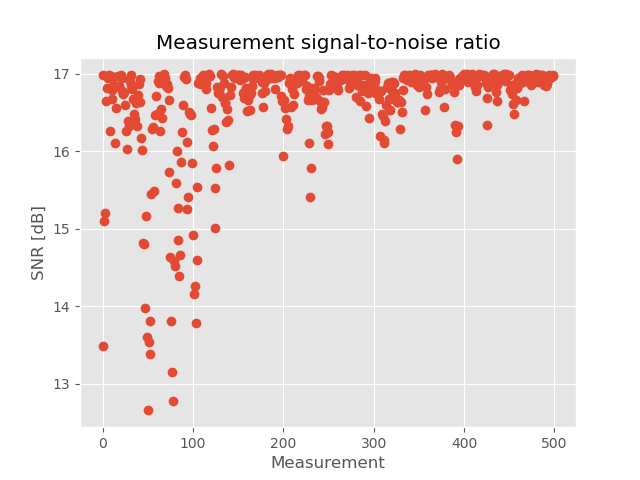

In [9]:
plot_snr(data)
plt.savefig('figs/snr.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


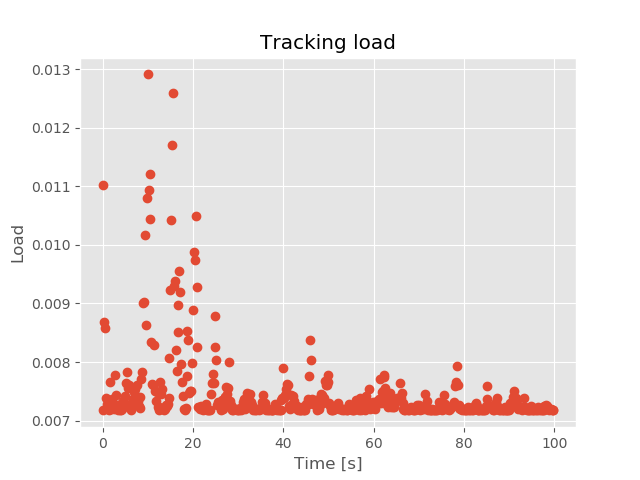

In [10]:
plot_tracking_load(data, t, dt)
plt.savefig('figs/load.pdf', bbox='tight', format='pdf')

<IPython.core.display.Javascript object>


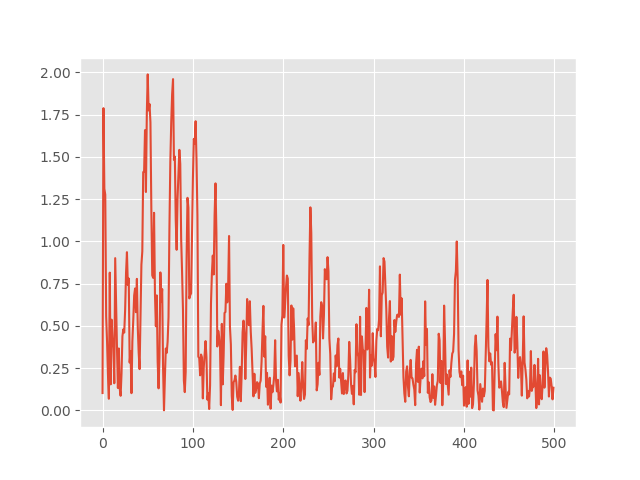

In [11]:
plot_angular_error(data)

<IPython.core.display.Javascript object>


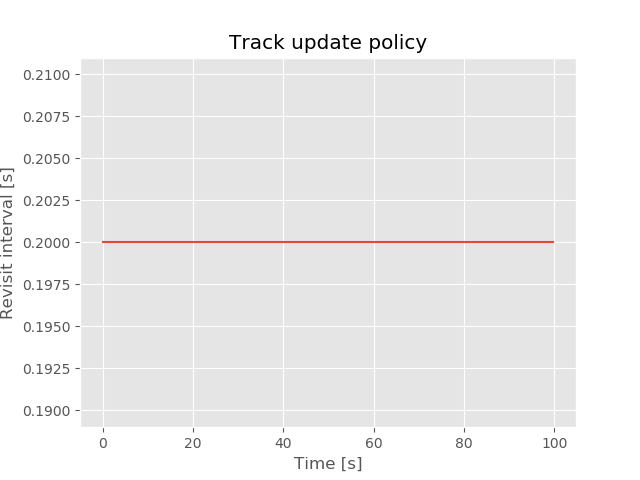

In [12]:
plot_update_policy(data, t, dt)
plt.savefig('figs/update_policy.pdf', bbox='tight', format='pdf')

# Benchmark dataset

## Task 1. Load the dataset and create pandas data frame

In [13]:
trajectories = list()
for i in range(1, 6+1):
    trajectories.append(pd.read_csv('trajectories/traj_{}.csv'.format(i), header=None).to_numpy())

## Task 2. Visualize the dataset

### 3D trajectory

<IPython.core.display.Javascript object>


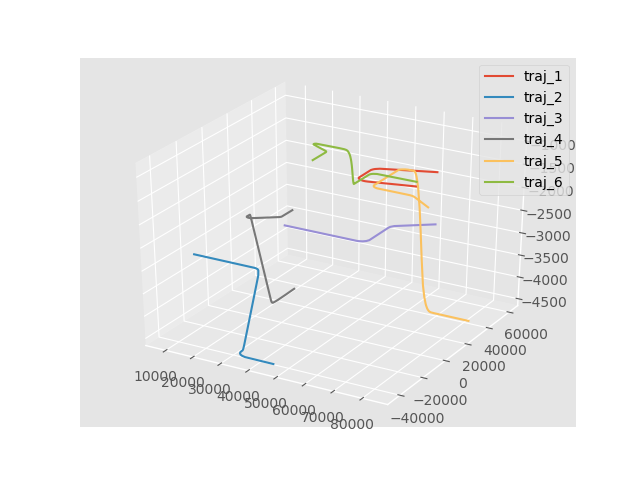

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(6):
    trajectory = trajectories[i]
    
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label='traj_' + str(i+1))
plt.show()
plt.legend()  

### 2D trajectory

<IPython.core.display.Javascript object>


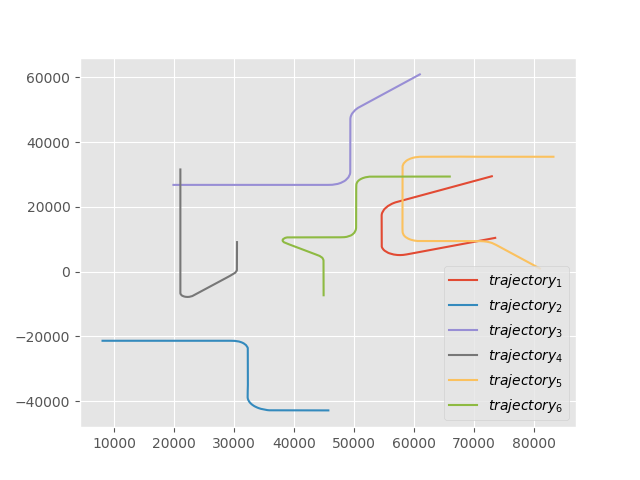

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(6):
    trajectory = trajectories[i]
    
    ax.plot(trajectory[:, 0], trajectory[:, 1], label='$trajectory_' + str(i+1) + '$')
plt.show()
plt.legend()

## Task 3. Create function to preprocess the data to be applicable for general tracking problem

The target state must be in form of (x, x', x'', y, y', y'') etc. with spesific model order and dimensions. Note that this is applicable only for simulations where position is tracked. 

In [15]:
def preprocess_trajectory_data(trajectory, dim, order):
    traj_trunc = trajectory[:, :dim]  # get the data up to desired dimension
    states = np.zeros((traj_trunc.shape[0], traj_trunc.shape[1] * (order+1)))  # Add additional dimensions based on the order
    states[:, ::(order+1)] = traj_trunc
    return states

In [16]:
preprocess_trajectory_data(trajectories[0], 2, 2)[:5, :]

array([[72944.,     0.,     0., 29473.,     0.,     0.],
       [72942.,     0.,     0., 29471.,     0.,     0.],
       [72939.,     0.,     0., 29470.,     0.,     0.],
       [72937.,     0.,     0., 29469.,     0.,     0.],
       [72934.,     0.,     0., 29468.,     0.,     0.]])

## Task 3. Simulate Kalman filter on the first trajectory

### Create simulation objects

In [82]:
trajectory = preprocess_trajectory_data(trajectories[1], dim=2, order=1)

target = TargetOnTrajectory(trajectory)

tracker = kinematic_kf(
    dim=2, 
    order=1,
    dt=dt
)

radar = Radar2D(
    sn0=50,
    beamwidth=np.pi/64,
    prob_f=1e-8,
    order=1,
)

update_policy = ResidualUpdatePolicy(v0=1, K_max=1000)

### Simulate

In [83]:
target.reset()
tracker.x = target.x
tracker.P = np.eye(target.x.size) * 1000
tracker.Q = np.eye(target.x.size) * 5e-7
data = simulation_loop(target, radar, tracker, update_policy, 13500)

<IPython.core.display.Javascript object>


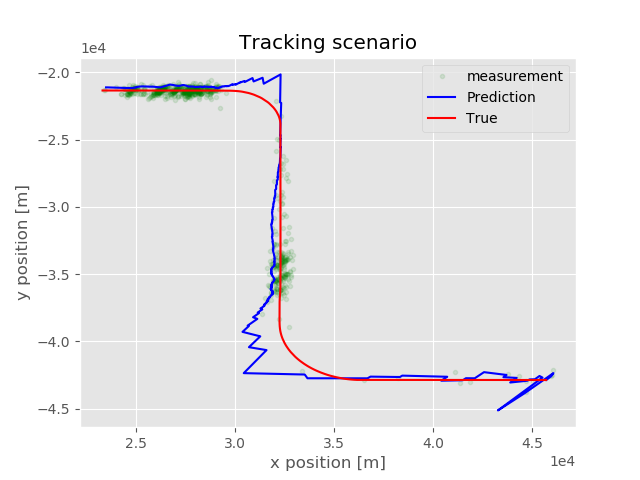

In [84]:
plot_scenario(data, order=1)

<IPython.core.display.Javascript object>


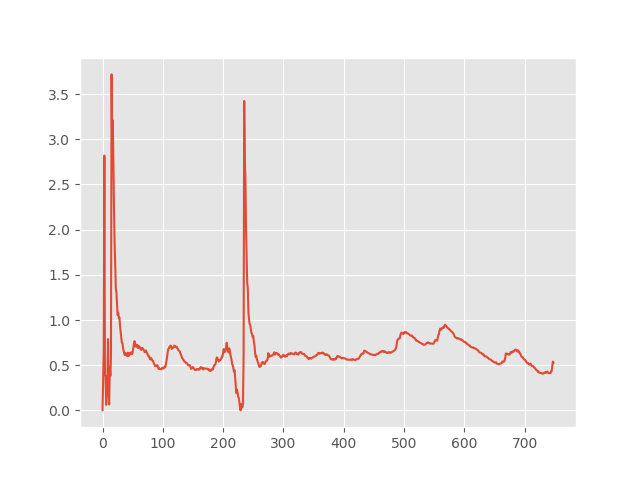

In [85]:
plot_angular_error(data)

<IPython.core.display.Javascript object>


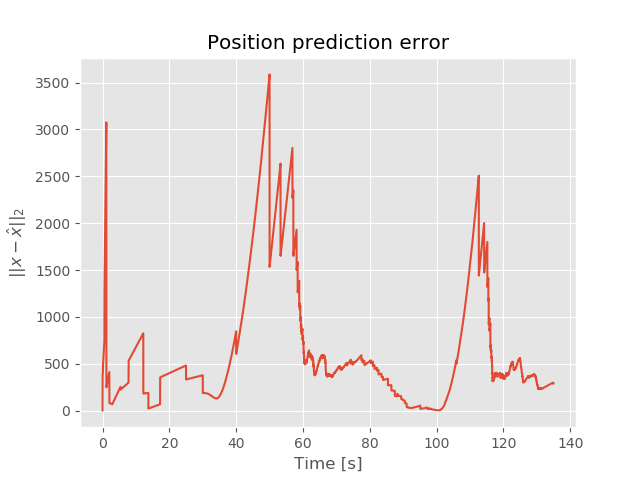

In [86]:
plot_prediction_error(data, np.arange(13500)*dt, 1)

<IPython.core.display.Javascript object>


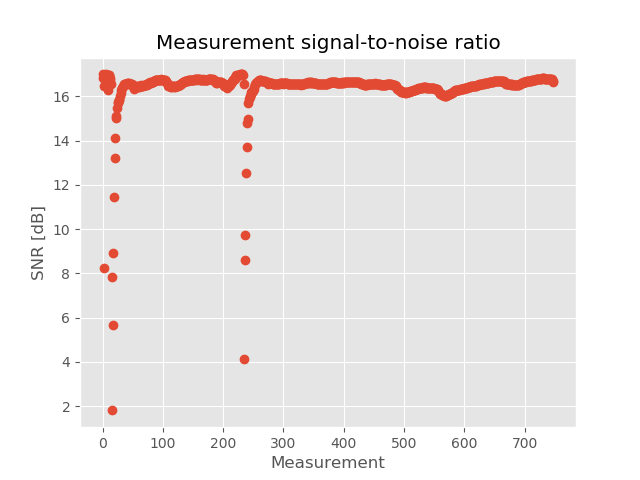

In [87]:
plot_snr(data)

<IPython.core.display.Javascript object>


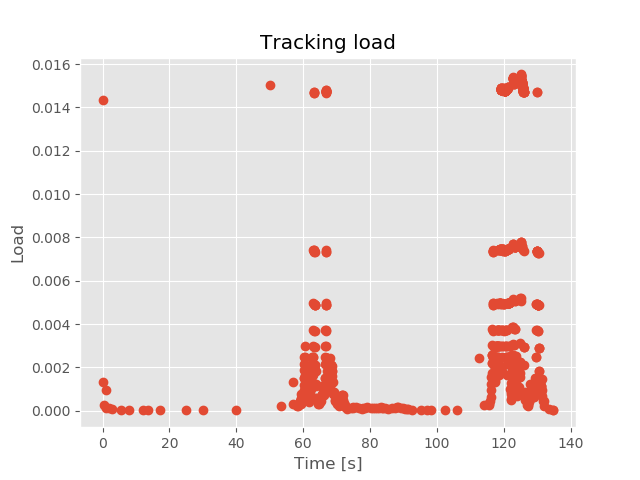

In [88]:
plot_tracking_load(data, np.arange(13500)*dt, dt)

In [92]:
np.sum([measurement.n_dwells for measurement in data.measurements])*0.01 /13500*dt

2.1373689193496415e-05

<IPython.core.display.Javascript object>


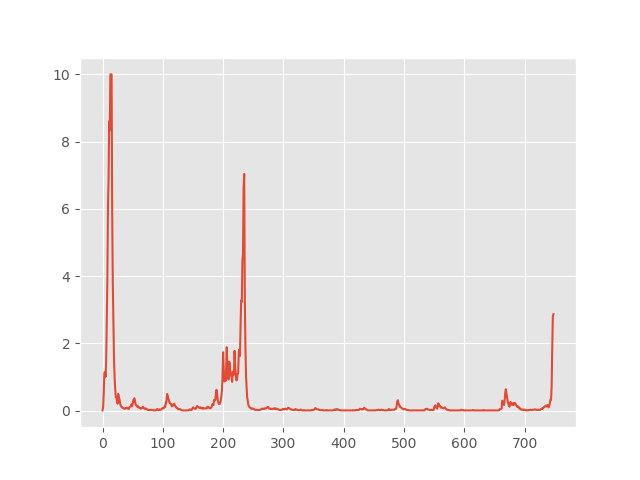

In [97]:
plt.figure()
plt.plot(data.revisit_intervals*dt)

In [99]:
(data.revisit_intervals*dt).sum()

219.68

<IPython.core.display.Javascript object>


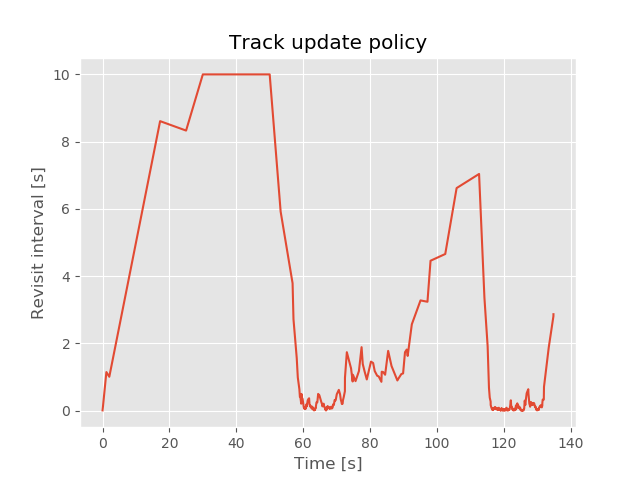

In [89]:
plot_update_policy(data, np.arange(13500)*dt, dt)